In [1]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan


In [15]:
from filter_data import *

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [16]:
from load_and_clean import *

update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')

global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')

mobility_data_apple, mobility_data_google = load_clean('mobility')

sd_data = load_clean('IHME intervention')

#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

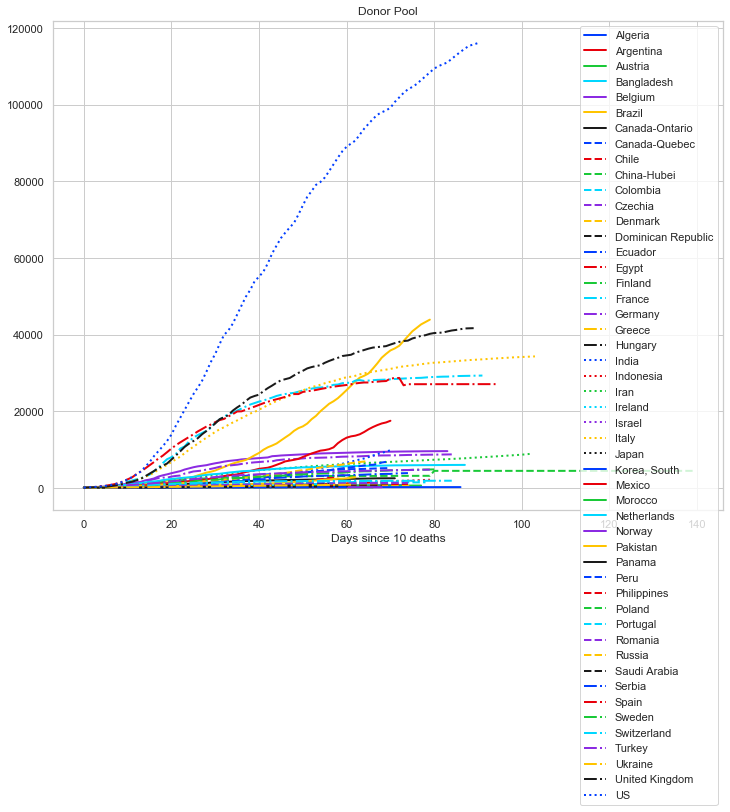

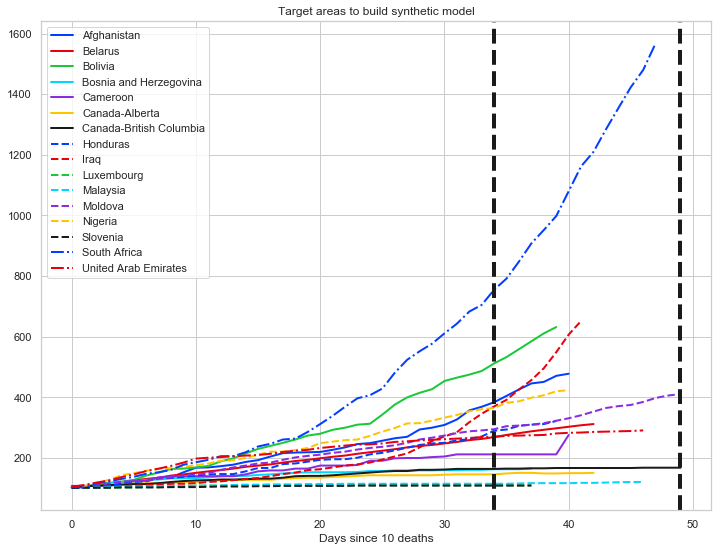

In [17]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})

global_deaths_filtered = create_filtered_data(global_deaths, 100 )

sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)
  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)


plt.show()


In [18]:
mobility_global = mobility_data_google.pivot_table(index='date', values='retail_and_recreation_percent_change_from_baseline', columns='country_region')

google_work_country = mobility_data_google.pivot_table(index='date', columns='country_region', values='workplaces_percent_change_from_baseline')
global_google = google_work_country[google_work_country.lt(-30)].apply(pd.Series.first_valid_index)
google_work_us = mobility_data_google[mobility_data_google.country_region ==  "United States"].pivot_table(index='date', values=mobility_data_google.columns[9], columns='sub_region_1')
us_google = google_work_us[google_work_us.lt(-30)].apply(pd.Series.first_valid_index)
google_social = pd.DataFrame(data=pd.concat([global_google, us_google]), columns=['date'])
google_social['date'] = pd.to_datetime(google_social['date'])
google_social['name'] = google_social.index

In [19]:
rolling_average_duration = 5

daily_global_raw = create_filtered_data(global_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us_raw = create_filtered_data(usdeaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_uscounties_raw = create_filtered_data(uscounties_deaths,5).diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]


In [20]:
from get_social_distancing import *
print(sd_data.columns)
intervention_tried = sd_data.columns[7]


Index(['name', 'country', 'admin1', 'Mass gathering restrictions',
       'Stay at Home Order', 'Educational facilities closed',
       'Initial business closures', 'Non-essential services closed',
       'Travel severely limited', 'Source Mass gathering restrictions',
       'Source Stay at Home Order', 'Source Educational facilities closed',
       'Source Initial business closure',
       'Source Non-essential services closed',
       'Source Travel severely limited', 'last date'],
      dtype='object')


In [21]:
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

last date
Exceptions are []


In [22]:
print(educational_distancing)

     country               name            last date       date
0    Germany  Baden-Wurttemberg  2020-03-21 00:00:00 2020-03-21
1    Germany            Bavaria  2020-03-21 00:00:00 2020-03-21
2    Germany             Berlin  2020-03-23 00:00:00 2020-03-23
3    Germany        Brandenburg  2020-03-18 00:00:00 2020-03-18
4    Germany             Bremen  2020-03-22 00:00:00 2020-03-22
..       ...                ...                  ...        ...
143    Malta              Malta  2020-03-17 00:00:00 2020-03-17
144   Cyprus             Cyprus  2020-03-24 00:00:00 2020-03-24
145  Iceland            Iceland  2020-03-24 00:00:00 2020-03-24
146    China        China-Hubei  2020-01-23 00:00:00 2020-01-23
147    India              India  2020-03-24 00:00:00 2020-03-24

[148 rows x 4 columns]


In [23]:
rolling_average_duration = 7


all_data = pd.concat([global_deaths, usdeaths], axis=1)  
all_data = pd.concat([all_data, uscounties_deaths], axis=1)

all_data_daily = all_data.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

all_data_cases = pd.concat([global_cases, uscases], axis=1) 

all_data_cases = pd.concat([all_data_cases, uscounties_cases], axis=1)


all_data_cases_daily = all_data_cases.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]


In [24]:
newdf=filter_data_by_intervention(usdeaths, educational_distancing)
newdf_global=filter_data_by_intervention(global_deaths, educational_distancing)
newdf_uscounties=filter_data_by_intervention(uscounties_deaths, educational_distancing)

cases_intervention_adjusted = filter_data_by_intervention(all_data_cases, educational_distancing)
deaths_intervention_adjusted = filter_data_by_intervention(all_data, educational_distancing)
deaths_intervention_adjusted_google =  filter_data_by_intervention(all_data, google_social)

rolling_average_duration = 7

daily_global = newdf_global.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_us = newdf.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
daily_uscounties = newdf_uscounties.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

cases_intervention_adjusted_daily = cases_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily = deaths_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily_google = deaths_intervention_adjusted_google.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

cases_intervention_adjusted_daily.index = cases_intervention_adjusted_daily.index-rolling_average_duration
deaths_intervention_adjusted_daily.index = deaths_intervention_adjusted_daily.index-rolling_average_duration
deaths_intervention_adjusted_daily_google.index = deaths_intervention_adjusted_daily_google.index-rolling_average_duration

In [25]:

targets = ['New York']# 'Italy', 'Spain', 'United Kingdom', 'France']

singVals = 5

    


for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(1,10):
        temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, i)

        return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12,
                                   exclude=[target], animation=camera, showDonors=False, silent=False, showPlots=True)
    

#animation = camera.animate()
#HTML(animation.to_html5_video())

    
    #HTML(animation_final.to_jshtml())

    #animation_final.save('../animations/'+target+' no donors new.mp4')

['Austria', 'Belgium', 'Bulgaria', 'China-Hubei', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'India', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 

UnboundLocalError: local variable 'error' referenced before assignment

<Figure size 1152x432 with 0 Axes>

In [ ]:
targets = ['New York']#, 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
donorpool = ['Italy', 'Spain', 'France', 'China-Hubei']
singVals = 2

move_intervention = 10
for target in targets:
    fig = plt.figure(figsize=(16,6))
    camera = Camera(fig)
    for i in range(1,10):
        new_value = synth_control_predictions([deaths_intervention_adjusted_daily],40,2+i, "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, donorPool=donorpool, animation=camera, showDonors=True, silent=False )
    animation = camera.animate(interval=300)
HTML(animation.to_html5_video())
#animation.save('../animations/'+target+' predictions.mp4')
#temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, move_intervention)
        #synth_control_predictions(pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1),45,25, "Deaths Data", 
                              #singVals, ylimit=[], savePlots=False, do_only=[target+" -"+str(move_intervention)], 
                              # showstates=10, svdSpectrum=False, showDonors=False,
                              # exclude=[target])
   

In [ ]:
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

rolling_average_duration = 7
deaths_intervention_adjusted = filter_data_by_intervention(all_data, educational_distancing)
deaths_intervention_adjusted_daily = deaths_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily.index = deaths_intervention_adjusted_daily.index-rolling_average_duration

cases_intervention_adjusted = filter_data_by_intervention(all_data_cases, educational_distancing)
cases_intervention_adjusted_daily = cases_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
cases_intervention_adjusted_daily.index = cases_intervention_adjusted_daily.index-rolling_average_duration


In [ ]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
lambdas=[1,0.01]
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

#targets = [ 'New York', 'Illinois', 'Belgium', 'Switzerland', 'New Jersey', 'France', 'Italy', 'United Kingdom']# 'Ohio', 'Sweden']
#targets = newdf.columns
high_thresh = 55
low_thresh = 50
#targets = random.sample(list(deaths_intervention_adjusted_daily.columns),80)
targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index


donorpool = sizes[sizes>=high_thresh].index


print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([df, df1],high_thresh, low_thresh,
                                            "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[], svdSpectrum=False, silent=True, showDonors=False, showPlots=False, lambdas=lambdas, mRSC=False, error_thresh = 1)
        weight_features.append(newdata)
    except ValueError:
        print(target)
        continue
feature_list = pd.DataFrame((weight_features))
feature_list.index=targets
feature_list.fillna(0, inplace=True)
#feature_list = feature_list.apply(lambda x: x/x.max(), axis=1)
feature_columns = feature_list.columns
kmeans = KMeans(n_clusters=5)
y = kmeans.fit_predict(feature_list[feature_columns])
feature_list.insert((feature_list.shape[1]),'KMeans',y)
feature_list.groupby('KMeans').groups
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_method='leaf')
clustering_labels = clusterer.fit_predict(feature_list[feature_columns])
feature_list['DB'] = clustering_labels
feature_list.groupby('DB').groups


In [ ]:
num_groups = len(feature_list.groupby('DB').groups)
plt.rcParams.update({'font.size': 8})
plt.rcParams['figure.figsize'] = (20.0, num_groups*6.0)
group1 = list(feature_list.groupby('DB').groups[-1])
for i in range(num_groups):
    group = (list(feature_list.groupby('DB').groups[i-1]))
    ax = plt.subplot(num_groups,2,2*i+1)

    df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
    ax = plt.subplot(num_groups,2,2*i+2)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
    all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

In [ ]:
plt.rcParams['figure.figsize'] = (12,9.0)
plt.rcParams.update({'font.size': 12})


targets = ['Connecticut', 'Sweden', 'California', 'Michigan', 'Netherlands', 'Ohio', 'Indiana']
deaths_intervention_adjusted_daily[targets].plot()

In [ ]:
plt.rcParams['figure.figsize'] = (20,9.0)

group=['India']
ax = plt.subplot(1,2,1)

df[group].plot(ax = ax, xlim=[0,60]), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths')
ax = plt.subplot(1,2,2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
all_data_daily[group].loc['2020-03-02':,:].plot(ax = ax), plt.legend(), plt.xlabel('Chronological Date'), plt.ylabel('Moving average of daily deaths')

In [ ]:
clusters = []
epsilon_range = np.arange(0.005,3,0.01)
for epsilon in epsilon_range:
    clustering = DBSCAN(eps=epsilon, min_samples=4).fit(feature_list[feature_columns].values)
    clusters.append(len(np.unique(clustering.labels_)))
plt.rcParams['figure.figsize'] = (8, 6)
plt.plot(epsilon_range, clusters)

eps = epsilon_range[np.argmax(clusters)]
eps = epsilon_range[random.choice(np.argwhere(clusters == np.amax(clusters)))]
print(eps)
#eps=.28
clustering = DBSCAN(eps=eps, min_samples=4).fit(feature_list[feature_columns].values)    
try:
    feature_list['DB'] = clustering.labels_
except KeyError:
    feature_list.insert((feature_list.shape[1]),'DB',clustering.labels_)
feature_list.groupby('DB').groups

In [ ]:
plt.rcParams.update({'font.size': 14})
list_of_clusters = ['Austria', 'Michigan', 'Sweden', 'Connecticut', 'Maryland', 'California', 'New York']
num_clusters = len(list_of_clusters)
plt.rcParams['figure.figsize'] = (8.0, num_clusters*6.0)

i=1
for clusters in list_of_clusters:
    ax = plt.subplot(num_clusters,1,i)
    deaths_intervention_adjusted_daily[clusters].plot(ax=ax), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths'), 
    cases_intervention_adjusted_daily[clusters].plot(ax=ax, linestyle=":", secondary_y=True), plt.ylabel('Moving Average Daily Cases'), plt.legend(),
    plt.xticks(rotation=45)
    i = i+1
                                                                                                

In [ ]:
plt.rcParams['figure.figsize'] = (24.0, 12.0)
ax = plt.subplot(4,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,3)
deaths_intervention_adjusted_daily[['Austria', 'Czechia', 'Denmark', 'Hungary','Wisconsin']].plot(ax=ax), plt.xlim(0,60),

#deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), 

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

plt.plot()
ax = plt.subplot(4,2,5)

deaths_intervention_adjusted_daily[['Alabama', 'Mississippi', 'Missouri' ]].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,6)

deaths_intervention_adjusted_daily[['District of Columbia', 'Iowa']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,7)

deaths_intervention_adjusted_daily[['Georgia', 'Texas']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(4,2,8)

deaths_intervention_adjusted_daily[[ 'United Kingdom', 'New York', 'Italy', 'Spain']].plot(ax=ax), plt.xlim(0,60),

plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
ax = plt.subplot(2,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden', 'California' ]].plot(ax=ax), plt.grid(),
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,3)

deaths_intervention_adjusted_daily[['Ireland', 'Colorado']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California', 'Indiana']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (20.0, 24.0)
plt.xlim([0,60])
for i in range(len(feature_list.groupby('DB').groups)):
    ax = plt.subplot(3,2,i+1)
    plt.xlim([0,60])
    group = (list(feature_list.groupby('DB').groups[i-1]))
    df[group].plot(ax = ax), plt.legend(), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths'),plt.grid()

In [ ]:
states = list(set(usstates['state'].values))
print(states)

In [ ]:
high_thresh = 40
low_thresh = 35
targets = usstates
#excludelist = group2.copy()

sizes = deaths_intervention_adjusted_daily[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>low_thresh].index
donorpool = sizes[sizes>high_thresh].index
print(targets)
print(donorpool)
singVals = 3
weight_features = []
move_intervention = 10
for target in targets:
  
    try:
        newdata = synth_control_predictions([deaths_intervention_adjusted_daily[targets]],high_thresh, low_thresh,
                                            "Daily Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                              svdSpectrum=False, silent=True, showDonors=False, mRSC=False, showPlots=False)
        #newdata = synth_control_predictions(deaths_intervention_adjusted_daily,high_thresh, low_thresh,
        #                                    "Deaths Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
        #                       exclude=excludelist, svdSpectrum=False, silent=False, showDonors=False, donorPool=group1 )
        
    except ValueError:
        print(target)
        continue


In [ ]:
#plt.yscale('log')
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))

newdf['New York'].plot(color='k'), newdf_global['Spain'].plot(color='g'), newdf_global['Italy'].plot(),
newdf_global['United Kingdom'].plot(color='b'), newdf_global['France'].plot(color='m'), plt.legend()
plt.show()
plt.figure(figsize=(8,6))
daily_us['New York'].plot(color='k'), daily_global['Spain'].plot(color='g'), daily_global['Italy'].plot(),
daily_global['United Kingdom'].plot(color='b'), daily_global['France'].plot(color='m'),
plt.xlabel('Days since non-essential businesses shut down'), plt.ylabel('5-day moving average of daily death count'), plt.legend()

In [ ]:
fig, ax = plt.subplots(1,1)
tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams.update({'font.size': 10})
label_markings = ax.get_xticklabels()
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': 14})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US'), tri_state.loc['2020-03-07':].plot(ax=ax, label="New York"), 
us_minus_new_york.loc['2020-03-07':].plot(ax=ax,color='k', label="US minus New York"), plt.ylabel('Moving Average Daily Deaths'), 

all_data_cases_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-03-07':].plot(ax=ax, label="New York Cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-03-07':].plot(ax=ax, label="US minus New York Cases", secondary_y=True,linestyle=":"), plt.legend(), plt.ylabel('Moving Average Daily Cases')
plt.setp( ax.get_xticklabels(), visible=True), plt.legend()
#deaths_intervention_adjusted_daily['Maryland'].plot(), deaths_intervention_adjusted_daily['Connecticut'].plot(), plt.legend(), plt.grid()



In [ ]:
df = create_peak_clusters(deaths_intervention_adjusted_daily,7)
plt.figure(figsize=(16,12))
#fig, ax = plt.subplots(1,1)

plt.rcParams.update({'font.size': 12})
tick_spacing = 30
# this is a bug in matplotlib
#plt.rcParams['figure.figsize'] = (24.0, 18.0)

#label_markings = ax.get_xticklabels()
#ax.set_xticklabels(label_markings, rotation=45)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(df['days to peak'], (df['peak value']), s=2*df['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention'), plt.title('Marker Size = Death Count when intervention applied', fontdict = {'fontsize' : 16}),
plt.ylabel('Peak value'),


variablelabel = df.index

for i, txt in enumerate(variablelabel):
    if(df['peak value'][i]>3500):
        plt.annotate(txt, (df['days to peak'][i], df['peak value'][i]+20))



In [ ]:

tick_spacing = 30
targets = ['Los Angeles-California', 'Maryland']
# this is a bug in matplotlib
df = deaths_intervention_adjusted_daily
plt.rcParams['figure.figsize'] = (8.0, 6.0)
df[targets].plot(), plt.legend()

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (24.0, 48.0)

plot_target = ['Sweden', 'Belgium', 'Netherlands', 'Spain', 'New York', 'Italy', 'Florida', 'India']
plot_us = [ 'Texas', 'Illinois','Maryland', 'Indiana', 'Virginia', 'Tennessee', 'North Carolina', 'Iowa', 'Arizona',
          'Wisconsin', 'South Carolina', 'Minnesota', 'Nebraska', 'Delaware', 'Kansas', 'New Mexico', 
           'New Hampshire', 'North Dakota', 'Florida', 'Michigan','Wyoming']
plot_us=newdf.columns
newfig=[16,32,48]
for i in range(1,52):

    ax = plt.subplot(13,4, i)
    deaths_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, color='r', label='deaths')
    #plt.legend()
    
    cases_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, secondary_y=True, color='k', label='cases')
    #plt.legend()
    plt.title(plot_us[i-1])
    if i in newfig:
        print(i)
        plt.show()


In [ ]:
google_social = pd.DataFrame(data=global_google, columns= ['date'])

In [ ]:
trial = filter_data_by_intervention(all_data, google_social)

In [ ]:
mobility_data_google[mobility_data_google.country_region =='United States'].sub_region_1.unique()


In [ ]:
mobility_data_google.columns


In [ ]:
state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 32.0)

newfig=[16,32,48]

tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

plt.setp( ax.get_xticklabels(), visible=False)

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[6], columns='sub_region_1')
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    if i in newfig:
        print(i)
        plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (16.0, 32.0)
tick_spacing = 30
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

mobility_sweden = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "India"].pivot_table(index='date', values=mobility_data_google.columns[9], columns='sub_region_1')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
state_list=mobility_sweden.columns
total_figures = len(state_list)
num_rows = np.ceil(total_figures/4)
for i in range(1, total_figures+1):
    ax = plt.subplot(num_rows,4, i)
    plt.setp( ax.get_xticklabels(), visible=True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

    mobility_sweden[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
#    if i in newfig:
#        print(i)
#        plt.show()

In [ ]:
us_minus_newyork = all_data_daily['US'] - all_data_daily['New York']

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)

all_data_daily['New York'].plot(label="New York"),
all_data_daily['Massachusetts'].plot(), all_data_daily['New Jersey'].plot(),
all_data_daily['California'].plot(),
all_data_daily['Michigan'].plot(), plt.xticks(rotation=45),
plt.legend(), plt.grid()

# 

In [ ]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)

In [ ]:
def create_peak_clusters_date(df, threshold=5):
    df_temp = df
    df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
    df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
    df_cluster['peak value'] = df_temp.max()
    df_cluster['initial value'] = df_temp.iloc[0,:]
    df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
    global_peak_size = df_cluster.loc[df_cluster['sizes'] - df_cluster['days to peak'] > threshold]
    #plt.scatter(global_peak_size['days to peak'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']), 
    return global_peak_size

In [ ]:
df_temp = all_data_daily
df_cluster = pd.DataFrame(data=df_temp.idxmax(), columns=["days to peak"])
df_cluster['sizes']=df_temp.apply(pd.Series.last_valid_index)
df_cluster['peak value'] = df_temp.max()
df_cluster['initial value'] = df_temp.iloc[0,:]
df_cluster['sizes'] = df_cluster['sizes'].fillna(0)
global_peak_size = df_cluster.loc[pd.to_datetime(df_cluster['sizes']) - pd.to_datetime(df_cluster['days to peak']) > pd.Timedelta('5 days')]

In [ ]:
global_peak_size = create_peak_clusters(deaths_intervention_adjusted_daily)
global_peak_size_cases = create_peak_clusters(cases_intervention_adjusted_daily)

In [ ]:
all_data_threshold = create_filtered_data(all_data, 5)

In [ ]:
global_peak_size_thresh = create_peak_clusters(all_data_threshold.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:])

In [ ]:
country_population = pd.read_excel("../data/country_pop_WDI.xlsx")
county_population = pd.read_excel("../data/co-est2019-annres.xlsx", header=[3])
new = county_population['Unnamed: 0'].str.replace(".","").str.replace(" County","").str.split(pat=",", expand=True)
county_population['state']=new[1].str.strip()
state_population = county_population.groupby('state').sum()
us_state_population = pd.DataFrame()
us_state_population['Country'] = state_population.index
us_state_population['Value'] = state_population[[2019]].values

all_population = pd.concat([country_population, us_state_population], axis=0, ignore_index=True)

In [ ]:
county_population

In [ ]:
targets = ['Sweden', 'Denmark', 'Norway', 'Finland']
#targets = ['India', 'Russia', 'Brazil']
targets = ['Michigan', 'Netherlands']
targets = ['Connecticut', 'California', 'Sweden']

#targets = ['Austria', 'Czechia', 'Hungary']
plt.rcParams['figure.figsize'] = (20.0, 8.0)
ax = plt.subplot(1,2,2)
deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Moving average of daily deaths'), plt.grid()
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population')

In [ ]:
ax = plt.subplot(1,2,2)
all_data[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Total deaths'), plt.grid()
#plt.show()
ax = plt.subplot(1,2,1)
plt.barh(all_population[all_population.Country.isin(targets)].Country, all_population[all_population.Country.isin(targets)].Value, 
         color=list('bgrcyk')),plt.xlabel('Population')


In [ ]:
new[1].str.strip()

In [ ]:
targets = ['Massachusetts', 'Belgium', 'New York', 'Netherlands']
deaths_intervention_adjusted_daily[targets].plot(), plt.grid()

In [ ]:
deaths_peak = list(global_peak_size.index)
cases_peak = list(global_peak_size_cases.index)
common_places = set(deaths_peak).intersection(cases_peak)
common_places2 = list(set(global_peak_size.index) & set(global_peak_size_cases.index))

In [ ]:
global_peak_size['lags'] = global_peak_size.loc[common_places2, "days to peak"]-global_peak_size_cases.loc[common_places2, "days to peak"]

In [ ]:
plt.scatter(global_peak_size['lags'], (global_peak_size['peak value']), s=2*global_peak_size['initial value']),
variablelabel = global_peak_size.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size['peak value'][i]>500):
        plt.annotate(txt, (global_peak_size['lags'][i], global_peak_size['peak value'][i]+20))

        variablelabel = global_peak_size.index


In [ ]:
plt.figure(figsize=(16,12))
fig, ax = plt.subplots(1,1)


tick_spacing = 30
# this is a bug in matplotlib
plt.rcParams['figure.figsize'] = (16.0, 12.0)

label_markings = ax.get_xticklabels()
ax.set_xticklabels(label_markings, rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim([0,60])
plt.scatter(global_peak_size_cases['days to peak'], (global_peak_size_cases['peak value']), s=2*global_peak_size_cases['initial value']),
#plt.scatter(global_peak_size_thresh['days to peak'], (global_peak_size_thresh['peak value']), s=2*global_peak_size_thresh['initial value'], color='r'), 
plt.xlabel('Days to peak value since intervention'), plt.title('Marker Size = Cases Count when intervention applied', fontdict = {'fontsize' : 16}), plt.ylabel('Peak value'), plt.grid()
variablelabel = global_peak_size_cases.index

for i, txt in enumerate(variablelabel):
    if(global_peak_size_cases['peak value'][i]>1500):
        plt.annotate(txt, (global_peak_size_cases['days to peak'][i], global_peak_size_cases['peak value'][i]+20))

        variablelabel = global_peak_size.index

In [ ]:
plt.hist(global_peak_size_cases['days to peak'])

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)

all_data_daily[['Sweden', 'Norway', 'Denmark', 'Finland']].plot()

In [ ]:
# load and clean mobility data

mobility_data_apple = pd.read_csv("../data/applemobilitytrends-2020-05-30.csv")
mobility_data_google = pd.read_csv("../data/Global_Mobility_Report.csv", low_memory=False)

mobility_global = mobility_data_google.pivot_table(index='date', values='retail_and_recreation_percent_change_from_baseline', columns='country_region')

google_work_country = mobility_data_google.pivot_table(index='date', columns='country_region', values='workplaces_percent_change_from_baseline')
global_google = google_work_country[google_work_country.lt(-30)].apply(pd.Series.first_valid_index)
google_work_us = mobility_data_google[mobility_data_google.country_region ==  "United States"].pivot_table(index='date', values=mobility_data_google.columns[9], columns='sub_region_1')
us_google = google_work_us[google_work_us.lt(-30)].apply(pd.Series.first_valid_index)
google_social = pd.DataFrame(data=pd.concat([global_google, us_google]), columns=['date'])
google_social['date'] = pd.to_datetime(google_social['date'])
google_social['name'] = google_social.index



In [ ]:
#state_list = ['Massachusetts', 'New Jersey', 'New York', 'California', 'Washington']
state_list = newdf.columns
plt.rcParams['figure.figsize'] = (16.0, 45.0)

newfig=[16,32,48]

tick_spacing = 30
#print((state_list))

mobility_us = mobility_data_google.loc[mobility_data_google.country_region == 
                                       "United States"].pivot_table(index='date', values=mobility_data_google.columns[6], columns='sub_region_1')
states_reopenings = []
for i in range(1,52):
    ax = plt.subplot(13,4, i)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.setp( ax.get_xticklabels(), visible=False)

    #plt.setp( ax.get_xticklabels(), visible=False)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


    mobility_us[state_list[i-1]].plot(ax=ax, title = state_list[i-1])
    count = 0 
    max_days = 3
    min_mobility = -10
    end_date = -1
    for (date, value) in list(zip(mobility_us[state_list[i-1]].index,mobility_us[state_list[i-1]])):
        if value < min_mobility:
            count = 0
        elif value >= min_mobility:
            count += 1
        if count == max_days:
            end_date = date
    
    states_reopenings.append((state_list[i-1], datetime.datetime.strptime(end_date,'%Y-%m-%d')))
    #print(end_date, mobility_us[state_list[i-1]].index[0], mobility_us[state_list[i-1]].index[-1])
    
    if i in newfig:
        print(i)
        plt.show()

print(states_reopenings)


In [ ]:
'''
def create_filtered_data_and_date(df, threshold):
    pattern = re.compile('(Unknown|Unassigned)')
    newdf = pd.DataFrame()
    threshold_dates = {}
    for location in df.columns:
        if(pattern.search(location)):
            continue
        highnumber = df[df[location].gt(threshold)]
        if(len(highnumber)>0):
            threshold_dates[location] = datetime.datetime.strptime(df.loc[highnumber.index[0]:,location].index[0],'%Y-%m-%d')
            newdf = pd.concat([newdf, pd.DataFrame(columns=[location], data=df.loc[highnumber.index[0]:,location].values)], axis=1)
            
    return newdf,threshold_dates
'''


#daily_us = create_filtered_data(uscases,1)
daily_us, lockdown_dates = find_lockdown_date(state_list, uscases, mobility_us)
#print(daily_us)





In [ ]:


highnumber1 = uscases['Alabama'].gt(0)
print((highnumber1))
#print(df[highnumber])

#df.loc[df[highnumber].index[0]:,location].values
start_date = datetime.datetime.strptime('2020-05-26','%Y-%m-%d')
#tmp = df[df['Alabama'].index]
tmp = pd.DataFrame(pd.to_datetime(uscases['Alabama'].index))
#tmp = pd.to_datetime(df['col'])
highnumber2 = tmp.gt(start_date)
print((highnumber2))
highnumber = highnumber1[0] & highnumber2['date']
print(highnumber1)

In [ ]:
# find day since 10 deaths for each state
# count how many days after that reopening happens
# use states with higher number of days to predict the ones with lower and vice versa

reopening_delta = {}
for (state, date) in states_reopenings:
    try:
        reopening_delta[state] = (date - lockdown_dates[state]).days
    except:
        continue
        
print(reopening_delta) 


opened_states = []
closed_states = []
max_days = 60
min_days = 50


for state in reopening_delta:
    if reopening_delta[state] >= max_days or reopening_delta[state] < 0 :
        # less than zero for the ones which have not yet opened. 
        closed_states.append(state)
    elif reopening_delta[state] > min_days:
        opened_states.append(state)
    

print(opened_states)
print(closed_states)


In [ ]:
'''
return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12,
                                   exclude=[target], animation=camera, showDonors=False, silent=False, showPlots=True)
    
'''
for target in opened_states:
    trial =  pd.concat([daily_us[closed_states], daily_us[[target]]], axis=1)# daily_us[closed_states]# pd.concat([daily_us[closed_states], daily_us[opened_states]], axis=1)
    print(trial)
    #min_days = reopening_delta[target]
    return_value = synth_control_predictions([trial], 120,min_days, "Cases Data", singVals, ylimit=[], 
                               savePlots=False, do_only=[target], showstates=12,
                               exclude=[target], animation=camera, showDonors=True, silent=False, showPlots=True)

    #synth_control_predictions2(trial,max_days,min_days, "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
    #                           exclude=matching+matching_us, svdSpectrum=False)
    #except: 
    #    continue

In [ ]:
'''
return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 42,22, "5-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12,
                                   exclude=[target], animation=camera, showDonors=False, silent=False, showPlots=True)
    
'''
for target in closed_states:
    trial =  pd.concat([daily_us[opened_states], daily_us[[target]]], axis=1)# daily_us[closed_states]# pd.concat([daily_us[closed_states], daily_us[opened_states]], axis=1)
    print(trial)
    return_value = synth_control_predictions([trial], 120,min_days, "Cases Data", singVals, ylimit=[], 
                               savePlots=False, do_only=[target], showstates=12,
                               exclude=[target], animation=camera, showDonors=True, silent=False, showPlots=True)

    #synth_control_predictions2(trial,max_days,min_days, "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
    #                           exclude=matching+matching_us, svdSpectrum=False)
    #except: 
    #    continue